# 2025-02-26 Transient

## Last time

* Blasius activity

## Today
* Blasius working session
* Intro to transient problems
* Forward Euler method
* Observing instability
* Stability diagrams
* Energy dissipation

In [3]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

## Blasius working session bonus point ideas

- Instead of truncating the domain at $\eta \in [0, \eta_{\mathrm{max}}]$, make a [transformation](https://onlinelibrary.wiley.com/doi/10.1155/2013/753049) such that the domain becomes finite, and solve that equation.

- Instead of doing continuous math for evaluating derivatives, use a differentiation matrix, and investigate the accuracy of the resulting solution.

# Ordinary Differential Equations

Given initial condition $u_0 = u(t=0)$, find $u(t)$ for $t > 0$ that satisfies

$$ \dot u \equiv \frac{\partial u}{\partial t} = f(t, u) $$

| Application | $u$ | $f$ |
| --- | --- | --- |
| Orbital dynamics | position, momentum | conservation of momentum|
| Chemical reactions | concentration | conservation of atoms |
| Epidemiology | infected/recovered population | transmission and recovery |
| Heat transfer | temperature | conservation of energy |
| Seismology | displacement, momentum | conservation of momentum |

# Solving differential equations

## Linear equations

$$ \dot u = A(t) u + \text{source}(t)$$

* Autonomous if $A(t) = A$ and source independent of $t$

* Suppose $u$ and $a = A$ are scalars. Then exacty solution $u(t) = e^{at} u_0$

## Can do the same for systems

$$ y(t) = e^{A t} y_0 $$

### What does it mean to exponentiate a matrix?

Taylor series!

$$ e^A = 1 + A + \frac{A^2}{2} + \frac{A^3}{3!} + \dotsb $$
and there are many [practical ways to compute it](https://doi.org/10.1137/S00361445024180).

#### Question
Suppose that the diagonalization $A = X \Lambda X^{-1}$ exists and derive a finite expression for the matrix exponential using the scalar `exp` function.

# Forward Euler method

$$ u(t_{i+1}) := u(t_i + h) = u(t_i) + f(t_i)h $$

In [36]:
function ode_euler(f, u0; tfinal=10., h=0.1)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal) # When can this go wrong?
        h = tnext - t
        u += h * f(t, u)
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_euler (generic function with 1 method)

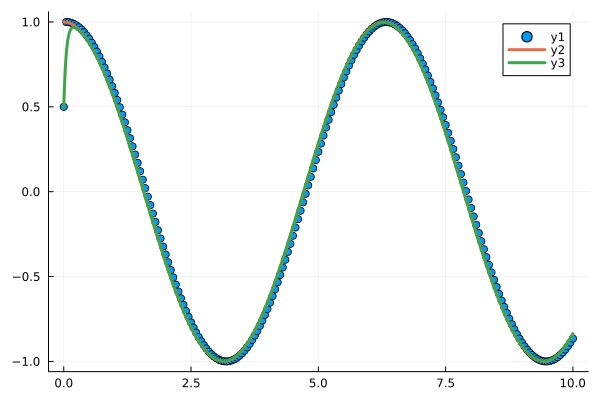

In [39]:
f1(t, u; k=20) = -k * (u .- cos(t))
analytic_u(t; k=20, u0=0.5) = ((k*sin(t) .+ k*k*cos(t)*exp(k*t))/(k*k + 1) + u0-k*k/(k*k+1))*exp(-k*t)
thist, uhist = ode_euler(f1, [0.5], tfinal=10, h=.05) # Try h = 0.005
scatter(thist, uhist[1,:])
plot!(cos)
plot!(analytic_u)

- **Question**: Intuitively, why does the solution resemble $\cos(t)$ at late times?

$$ u' + ku = k\cos(t), \quad u(0) = 0.5 $$

* The solution of the homogeneous equation, $u' + ku = 0$, is $c e ^{-kt}$
* At large $k$ and in "steady state", we anticipate the 2nd term on the left to be much larger than the first, which gives $u_{ss} \approx \cos(t)$. This would indeed mean that $ku \gg u'$.
* Analytic solution is

$$ u(t) = \left(\frac{\sin(t) + k\cos(t)}{k^2 + 1}ke^{kt} + u_0 - \frac{k^2}{k^2 + 1}\right) e^{-kt}$$

* Can you identify the transient and steady-state parts of the solution?

# Forward Euler on a linear system

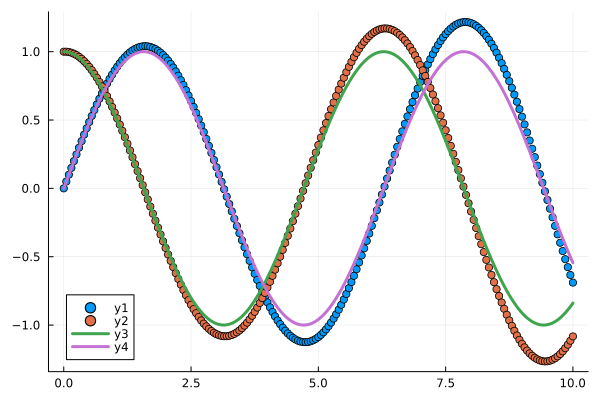

In [24]:
f2(t, u) = [0 1; -1 0] * u

thist, uhist = ode_euler(f2, [0, 1.], h=.05, tfinal=10) # Try h = 0.005
scatter(thist, uhist')
plot!([cos, sin])

In [5]:
eigen([0 1; -1 0])

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
2-element Vector{ComplexF64}:
 0.0 - 1.0im
 0.0 + 1.0im
vectors:
2×2 Matrix{ComplexF64}:
 0.707107-0.0im       0.707107+0.0im
      0.0-0.707107im       0.0+0.707107im

# Linear Stability Analysis

Why did Euler converge on the first problem (with sufficiently small steps) while always diverging on the second problem?

We can understand the convergence of methods by analyzing the test problem
$$ \dot u = \lambda u $$
for different values of $\lambda$ in the complex plane.
One step of the Euler method with step size $h$ maps
$$ u \to u + h \lambda u = \underbrace{(1 + h \lambda)}_{R(\underbrace{h \lambda}_{z \in \mathbb{C}})} u $$
where we have introduced the complex-valued function $R(z)$.

* **Question**: when does this map cause solutions to "blow up" and when is it stable?

# Stability diagrams (a property of methods)

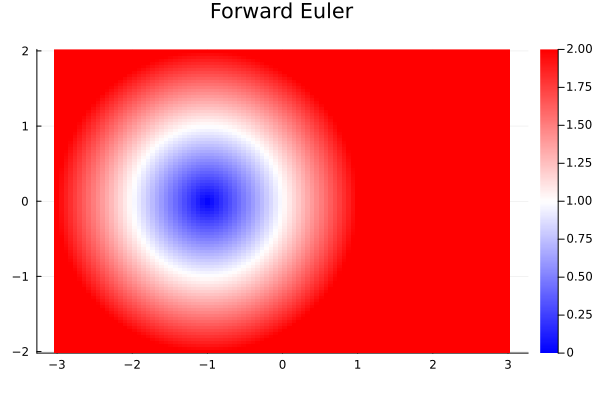

In [25]:
function plot_stability(Rz, title; xlims=(-3, 3), ylims=(-2, 2))
    x = LinRange(xlims[1], xlims[2], 100)
    y = LinRange(ylims[1], ylims[2], 100)
    heatmap(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2), aspect_ratio=:equal, title=title)
end
plot_stability(z -> 1 + z, "Forward Euler")

**Question**: with this in mind, why was forward Euler stable for

$$ u' = -ku + k\cos(t), \quad (k = 20, h = 0.05), $$

but not for

$$ u' = \begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix} u, \quad (h = 0.05)? $$

# Implicit methods

Recall that forward Euler is the step
$$ \tilde u(h) = u(0) + h f(0, u(0)) . $$
This can be evaluated **explicitly**; all the terms on the right hand side are known so the approximation $\tilde u(h)$ is computed merely by evaluating the right hand side.
Let's consider an alternative, **backward Euler** (or "implicit Euler"),
$$ \tilde u(h) = u(0) + h f(h, \tilde u(h)) . $$
This is a (generally) nonlinear equation for $\tilde u(h)$.
For the test equation $\dot u = \lambda u$, the backward Euler method is
$$ \tilde u(h) = u(0) + h \lambda \tilde u(h) $$
or
$$ \tilde u(h) = \underbrace{\frac{1}{1 - h \lambda}}_{R(h\lambda)} u(0) . $$

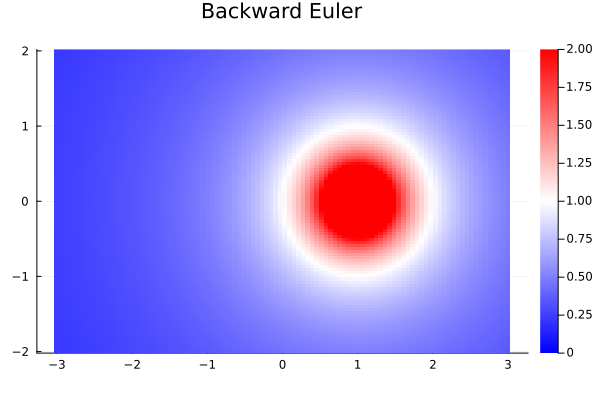

In [26]:
plot_stability(z -> 1 / (1 - z), "Backward Euler")

# Advection with centered stencil

Reminder: advection eq is $$ u_t + \underbrace{(\kappa u)_x}_{-f(t, u)} = 0 $$

In [40]:
function advect_center(t, u)
    n = length(u)
    dx = 2 / n
    uwrap = [u[end], u..., u[1]]
    f = zero(u)
    for i in 1:n
        f[i] = -(uwrap[i+2] - uwrap[i]) / (2*dx)
    end
    f
end

x = LinRange(-1, 1, 51)[1:end-1]
u0 = exp.(-9 * x .^ 2)
thist, uhist = ode_euler(advect_center, u0, h=.02, tfinal=1);

nsteps = 51


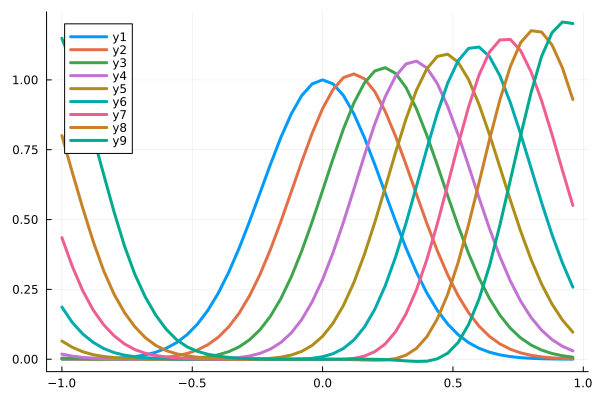

In [41]:
nsteps = size(uhist, 2)
@show nsteps
plot(x, uhist[:, 1:(nsteps÷8):end])

# Advection with upwind stencil

In [42]:
function advect_upwind(t, u)
    n = length(u)
    dx = 2 / n
    uwrap = [u[end], u..., u[1]]
    f = zero(u)
    for i in 1:n
        f[i] = -(uwrap[i+1] - uwrap[i]) / dx
    end
    f
end

x = LinRange(-1, 1, 51)[1:end-1]
u0 = exp.(-9 * x .^ 2)
@time thist, uhist = ode_euler(advect_upwind, u0, h=.02, tfinal=1);

  0.043606 seconds (26.21 k allocations: 1.297 MiB, 99.38% compilation time)


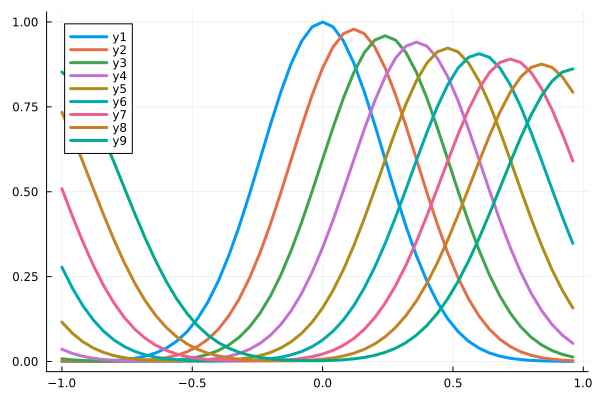

In [43]:
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:(nsteps÷8):end])

# Centered advection with Runge-Kutta

In [45]:
function ode_rk4(f, u0; tfinal=10., h=0.4)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        ydot1 = f(t, u)
        ydot2 = f(t+h/2, u + h/2*ydot1)
        ydot3 = f(t+h/2, u + h/2*ydot2)
        ydot4 = f(t+h, u + h*ydot3)
        u += h/6 * (ydot1 + 2*ydot2 + 2*ydot3 + ydot4)
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk4 (generic function with 1 method)

  0.286649 seconds (367.63 k allocations: 19.269 MiB, 99.76% compilation time)


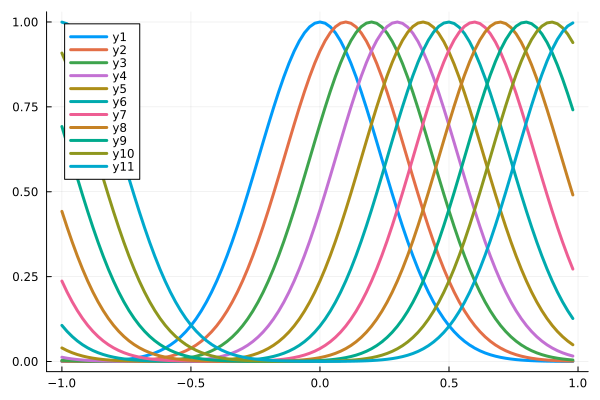

In [35]:
x = LinRange(-1, 1, 101)[1:end-1]
u0 = exp.(-9 * x .^ 2)
@time thist, uhist = ode_rk4(advect_center, u0, h=.05, tfinal=1);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:(nsteps÷8):end])